In [1]:
%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'png'
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sklearn as sk
import json

import numpy as np
import pandas as pd
import toolz
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import subsample.algorithms as subsample
%matplotlib inline

import pymongo
DB = pymongo.MongoClient('localhost', 27017)

In [3]:
from datetime import datetime

In [4]:
# import toyplot

import folium

import mplleaflet
import geopandas as gpd



In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [6]:
meetup_cities = pd.read_csv("data/meetup_cities.csv")

In [7]:
cities1000 = pd.read_csv("data/cities1000.csv")
# Dedupe cities by selecting the highest population entry
cities1000 = cities1000.groupby('ansiname', as_index=False, group_keys=False)\
                       .apply(lambda x: x.ix[x.population.idxmax()])

/Users/anto/.virtualenvs/meetup/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
meetup_cities.loc[meetup_cities.city == "New York",'city'] = 'New York City'  # Name consistency for join
cities = pd.merge(meetup_cities, cities1000, how='left', left_on='city', right_on='name')

In [9]:
cities_gb = cities[cities['country'] == 'gb']

In [145]:
cities_gb.iloc[:,'members']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [152]:
ax.legend?

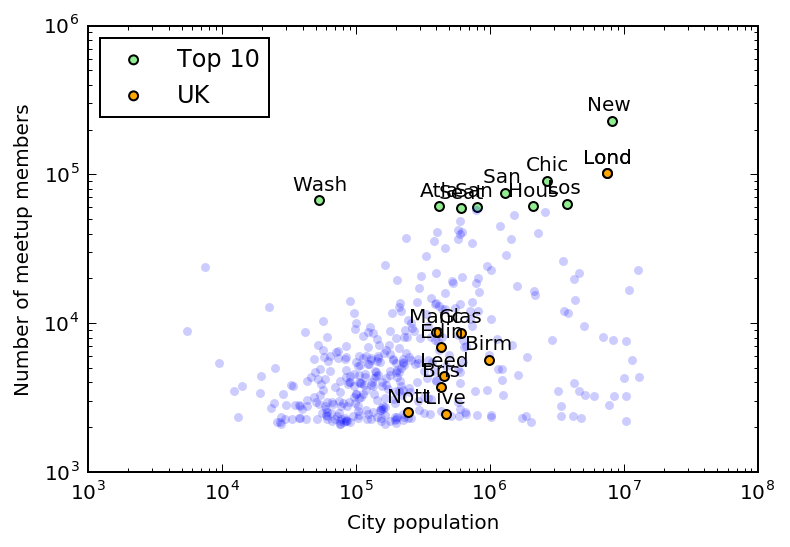

In [153]:
fig, ax = plt.subplots()
cities.head(10).plot(kind='scatter', loglog=True, x='population', y='members', alpha=1, ax = ax, color='lightgreen', label="Top 10")
cities.tail(-10).plot(kind='scatter', loglog=False, x='population', y='members', alpha=0.2, linewidths=0, ax = ax)
cities_gb.plot(kind='scatter', loglog=True, x='population', y='members', ax=ax, alpha=1, color='orange', label="UK")
for _, row in toolz.concatv(cities_gb.iterrows(), cities.head(10).iterrows()):
    ax.annotate(row['city'][:4], xy=(row['population'], row['members']*1.1),
               horizontalalignment='center', verticalalignment='bottom')
ax.set_xlabel("City population")
ax.set_ylabel("Number of meetup members")
ax.legend(loc='upper left', scatterpoints=1)
fig.savefig('figures/scatterplot_cities.pdf')

In [12]:
groups = pd.read_csv("crawler/groups.csv.gz").drop_duplicates(subset='id')
groups['topics'] = groups.topics.dropna().apply(json.loads)
groups['topics_urlkeys'] = groups.topics.dropna().apply(lambda x: ' '.join([i['urlkey'] for i in x]))

groups['category'] = groups.category.dropna().apply(json.loads)
groups['category_id'] = groups.category.dropna().apply(lambda x: x['id'])

# Topic modelling

In [13]:
def topic_modeling(text_data, max_df=0.95, min_df=0.02, max_features=1000, stop_words="english", n_topics=10,
                   n_top_words=10):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.02, max_features=max_features,
                                 stop_words='english')
    nmf = NMF(n_components=n_topics, random_state=1)
    pipeline_topic_modeling = make_pipeline(
            vectorizer,
            nmf,
    )
    pipeline_topic_modeling.fit_transform(text_data)
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(nmf.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print ""

In [156]:
topic_modeling(groups.query('category_id == 10').topics_urlkeys.dropna(), n_topics=5, n_top_words=30)

Topic #0:
self meditation spirituality improvement spiritual healing empowerment consciousness exploration growth personal wellness lifetransform yoga energy stress mindfulness transformation health development living relief life healthy coaching medicine alternative holistic lawofattraction support

Topic #1:
business networking marketing professional entrepreneurship strategy startup small women businesses entrepreneur smallbiz entrepreneurs referral owners womens startups prodev professionals technology online coaching internet media leadership socialnetwork creative innovation education young

Topic #2:
social singles fun newintown times socialnetwork diningout friends music nightlife women culture dating london dancing pubs 30s language new bars drinking professional livemusic relationships group 20s travel coffee young talking

Topic #3:
fitness outdoor sports excercise training healthy outdoors living group wellness hiking walkers health adventures womens nutrition yoga socials 

# Events

In [15]:
t_groups_ids = list(groups.loc[groups.category_id == 34,'id'])
t_events = list(DB.meetup.events.find({'group.id': {'$in': t_groups_ids}}))
for e in t_events:
    e['datetime'] = datetime.utcfromtimestamp(e['time']/1000)
tedf = pd.DataFrame(t_events)

In [179]:
# DB.meetup.events.find({'group.id': {'$in': t_groups_ids}}).count()

477169

In [17]:
len(t_events)

477169

In [18]:
DB.meetup.events.count()

2903232

In [19]:
nt_groups_ids = list(subsample.approximate_sample(groups.loc[groups.category_id != 34,'id'], 0.1))
nt_events = list(DB.meetup.events.find({'group.id': {'$in': nt_groups_ids}}))
for e in nt_events:
    e['datetime'] = datetime.utcfromtimestamp(e['time']/1000)
ntedf = pd.DataFrame(nt_events)

## When do people meet for Tech-related events?

In [31]:
sns.barplot?

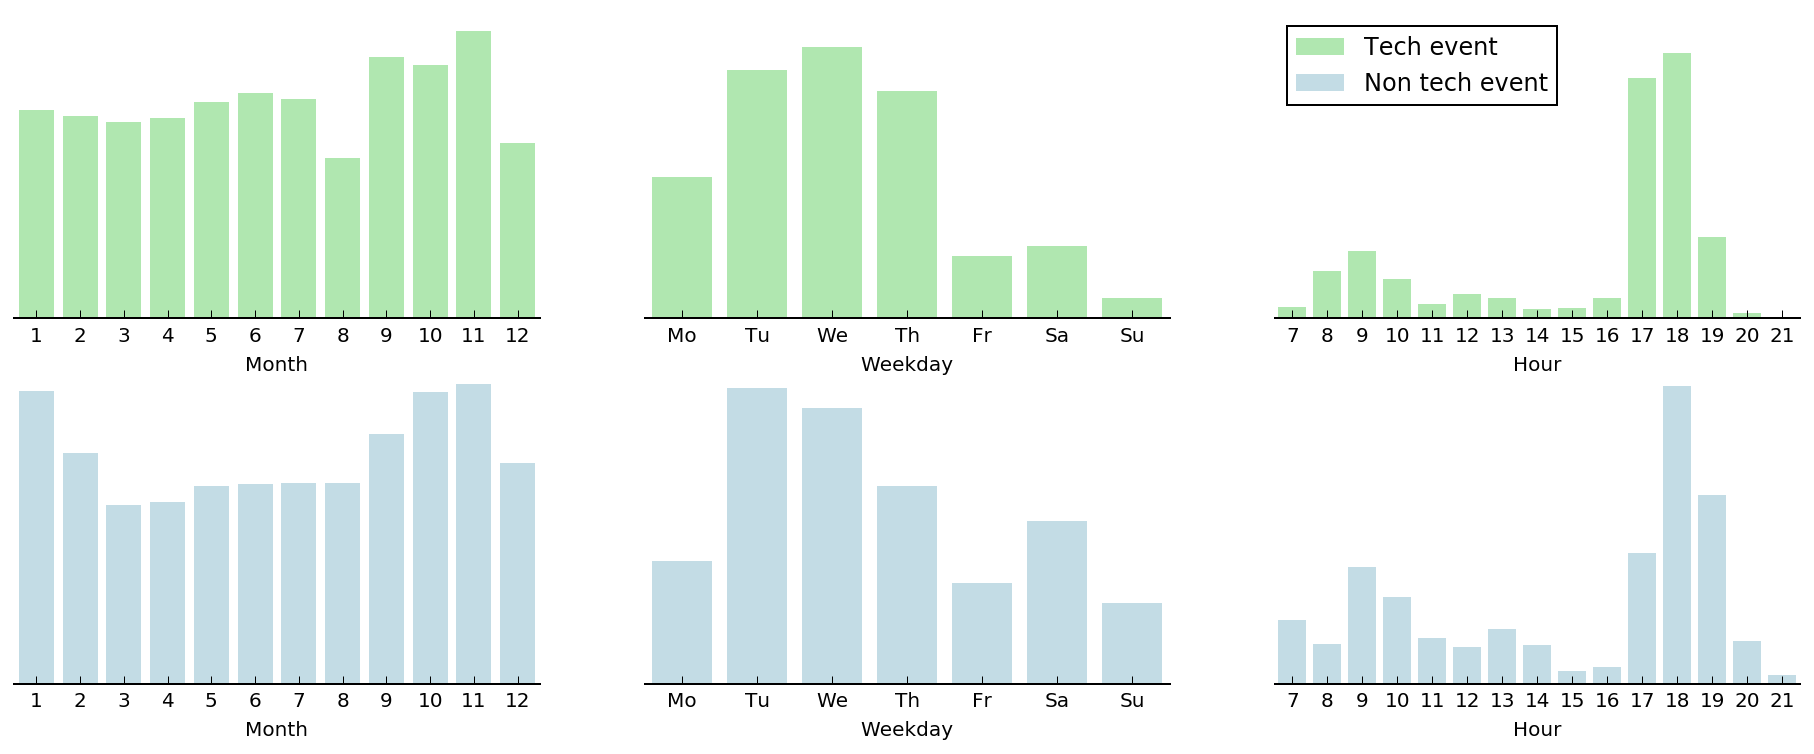

In [160]:
fig, ax = plt.subplots(figsize=(16,6), ncols=3, nrows=2)
month_grouper = lambda x: x.datetime.dt.month
weekday_grouper = lambda x: x.datetime.dt.weekday
hour_grouper = lambda x: x.datetime.dt.hour

for i, grouper in enumerate((month_grouper, weekday_grouper, hour_grouper)):
    grouped = tedf.groupby(grouper(tedf))
    grouped2 = ntedf.groupby(grouper(ntedf))
    a = sns.barplot(grouped.groups.keys(), (grouped.venue.count()/len(tedf)).tolist(), lw=0, color='lightgreen', ax=ax[0][i], alpha=0.8, label="Tech event")
    b = sns.barplot(grouped2.groups.keys(), (grouped2.venue.count()/len(ntedf)).tolist(), lw=0, color='lightblue', ax=ax[1][i], alpha=0.8, label="Non tech event")
#     sns.barplot('Mo,Tu,We,Th,Fr,Sa,Su'.split(","), adf.groupby(adf.datetime.dt.weekday).venue.count().tolist(), lw=0, color='lightgreen', ax=ax[1])
#     sns.barplot(df.index.tolist(), adf.groupby(adf.datetime.dt.hour).venue.count().tolist(), lw=0, color='lightgreen', ax=ax[2])
sns.despine(left=True)
for i in (0, 1):
    ax[i][0].set_xlabel("Month")
    ax[i][1].set_xlabel("Weekday")
    ax[i][2].set_xlabel("Hour")
    ax[i][1].set_xticklabels("Mo,Tu,We,Th,Fr,Sa,Su".split(","))
ax[0][2].set_xlim(5.5,20.5);
ax[1][2].set_xlim(4.5,19.5);
for ax_i in ax.ravel():
    ax_i.set_yticks([])
h1, l1 = ax[0][0].get_legend_handles_labels()
h2, l2 = ax[1][0].get_legend_handles_labels()
ax[0][2].legend(h1+h2, l1+l2, loc='upper left')
# ax[0].set_ylabel("")
plt.savefig("figures/when.pdf")

Events occur most frequently in the weekdays' evenings, and less frequently on the months of August and December.

In [120]:
m2 = folium.Map()
m2.add_cm.to_json()

In [139]:
mc = folium.MarkerCluster()
subsample.random.seed("meetups")
for event in subsample.reservoir_sample(t_events, 1000):
    try:
        lon, lat = event['venue']['lon'], event['venue']['lat']
        if lat == 0 and lon == 0: # Outliers
            continue
        marker = folium.Marker((lat, lon))
        marker.add_to(mc)
        folium.Popup(u'Event "{}" by "{}" on {}'.format(event['name'],
                                                       event['group']['name'],
                                                       event['datetime'])).add_to(marker)
    except KeyError:
        continue
m = folium.Map(tiles = 'CartoDB positron',
               location=(55,-3),
               zoom_start=5,
)
mc.add_to(m)
m.to_json
m.save("figures/map_tech_events.html")

Most events (~75%) are in London Greater Area, and ~16% in Shoreditch.

In [138]:
mc = folium.MarkerCluster()
subsample.random.seed("meetups")
for event in subsample.reservoir_sample(nt_events, 1000):
    try:
        lon, lat = event['venue']['lon'], event['venue']['lat']
        if lat == 0 and lon == 0: # Outliers
            continue
        marker = folium.Marker((lat, lon))
        marker.add_to(mc)
        folium.Popup(u'Event "{}" by "{}" on {}'.format(event['name'],
                                                       event['group']['name'],
                                                       event['datetime'])).add_to(marker)
    except KeyError:
        continue
m = folium.Map(tiles = 'CartoDB positron',
               location=(55,-3),
               zoom_start=5,
)
mc.add_to(m)
m
m.save('figures/map_nontech_events.html')

In [10]:
fig, ax = plt.subplots()
lons = []
lats = []
for event in events[:5000]:
    try:
        lon, lat = event['venue']['lon'], event['venue']['lat']
        lons.append(lon)
        lats.append(lat)
    except KeyError:
        continue
# ax.scatter(lons,lats, marker='.', alpha=0.1)
# mplleaflet.display(fig=fig, tiles=positron)


In [12]:
gb = gpd.read_file('data/lad.json')

In [41]:
gb.plot?

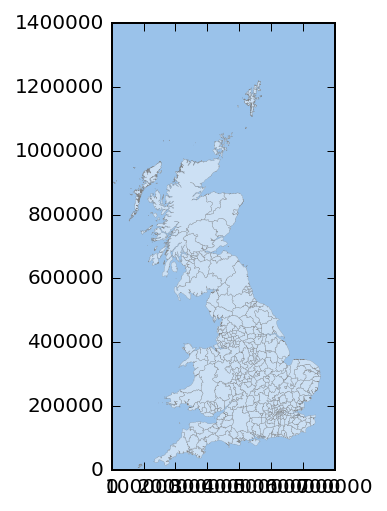

In [48]:
fig, ax = plt.subplots()
ax.set_axis_bgcolor("#9AC2EA")
original = dict(ellps='WGS84', datum='WGS84', proj='longlat')
gb.crs = original
gb.to_crs(epsg=27700).geometry.plot(facecolor='white', edgecolor='grey', linewidth=0.1, ax=ax)
# ax.scatter(lons, lats, marker='.', alpha=1)
ax.set_aspect(1)

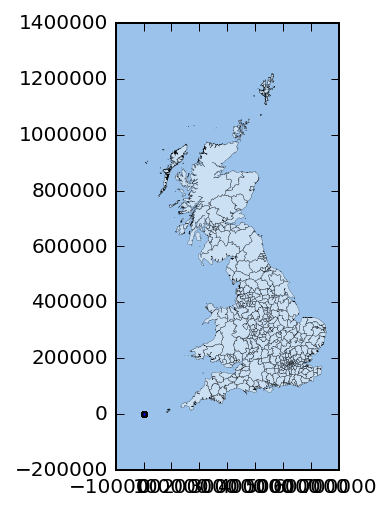

In [46]:
fig, ax = plt.subplots()
ax.set_axis_bgcolor("#9AC2EA")
original = dict(ellps='WGS84', datum='WGS84', proj='longlat')
gb.crs = original
gb.to_crs(epsg=27700).geometry.plot(facecolor='white', linewidth=0.1, ax=ax)
ax.scatter(lons, lats, marker='.', alpha=1)
ax.set_aspect(1)

In [90]:
for e in events:
    e.pop("_id")

In [97]:
DB.meetup.events.find().count()

477169

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import logging
logging.basicConfig(level=logging.DEBUG)

import geotiler

bbox = 11.78560, 46.48083, 11.79067, 46.48283

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

#
# download background map using OpenStreetMap
#
mm = geotiler.Map(extent=bbox, zoom=18)

img = geotiler.render_map(mm)

#
# create basemap
#
map = Basemap(
    llcrnrlon=bbox[0], llcrnrlat=bbox[1],
    urcrnrlon=bbox[2], urcrnrlat=bbox[3],
    projection='merc', ax=ax
)

map.imshow(img, interpolation='lanczos', origin='upper')

#
# plot custom points
#
x0, y0 = 11.78816, 46.48114 # http://www.openstreetmap.org/search?query=46.48114%2C11.78816
x1, y1 = 11.78771, 46.48165 # http://www.openstreetmap.org/search?query=46.48165%2C11.78771
x, y = map((x0, x1), (y0, y1))
ax.scatter(x, y, c='red', edgecolor='none', s=10, alpha=0.9)

# plt.savefig('ex-basemap.pdf', bbox_inches='tight')
plt.close()

ImportError: No module named basemap

In [ ]:
# Make a plot of the number of groups created in each category

In [238]:
groups['created_dt'] = pd.to_datetime(groups.created, unit='ms')

In [183]:
for i in xrange(45):
    try:
        print groups.query("category_id == {}".format(i)).iloc[0].category['shortname'], 
    except:
        pass

arts-culture career-business cars-motorcycles community-environment dancing education-learning fashion-beauty fitness food-drink games lgbt government-politics health-wellbeing hobbies-crafts language lifestyle book-clubs movies-film music new-age-spirituality outdoors-adventure paranormal parents-family pets-animals photography religion-beliefs sci-fi-fantasy singles socializing sports-recreation support tech writing


In [239]:
gg = groups.sort_values(by='created_dt')
# gg_tech = gg.query('category_id == 34')
# gg_arts = gg.query('category_id == 1')
# print gg_tech.groupby(gg_tech.created_dt.dt.year).count()[['category']]
# print gg_arts.groupby(gg_arts.created_dt.dt.year).count()[['category']]

In [254]:
gg.groupby('category_id').head()

,Unnamed: 0,category,city,country,created,description,group_photo,id,join_mode,lat,...,state,timezone,topics,urlname,utc_offset,visibility,who,topics_urlkeys,category_id,created_dt
0,0,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,2008-03-11 18:41:20
162176,162176,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,2008-03-11 18:41:20
255597,255597,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,2008-03-11 18:41:20
85028,85028,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,2008-03-11 18:41:20
273575,273575,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,2008-03-11 18:41:20
109196,109196,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approval,51.520000,...,17,Europe/London,"[{u'name': u'Film Industry', u'urlkey': u'film...",filmind-351,0,members,Film People,filmind dv screenwriters indiefilm video film-...,15,2008-03-19 21:32:51
128101,128101,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approval,51.520000,...,17,Europe/London,"[{u'name': u'Film Industry', u'urlkey': u'film...",filmind-351,0,members,Film People,filmind dv screenwriters indiefilm video film-...,15,2008-03-19 21:32:51
25016,25016,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approval,51.520000,...,17,Europe/London,"[{u'name': u'Film Industry', u'urlkey': u'film...",filmind-351,0,members,Film People,filmind dv screenwriters indiefilm video film-...,15,2008-03-19 21:32:51
162177,162177,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approval,51.520000,...,17,Europe/London,"[{u'name': u'Film Industry', u'urlkey': u'film...",filmind-351,0,members,Film People,filmind dv screenwriters indiefilm video film-...,15,2008-03-19 21:32:51
1,1,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approva

In [ ]:
a = gg.groupby('category_id').apply((x.created_dt.dt.year + x.created_dt.dt.month)).count()[['category_id']])

In [241]:
timeseries = a.rename(columns={'category_id': 'meetup_groups'}).reset_index().fillna(0)

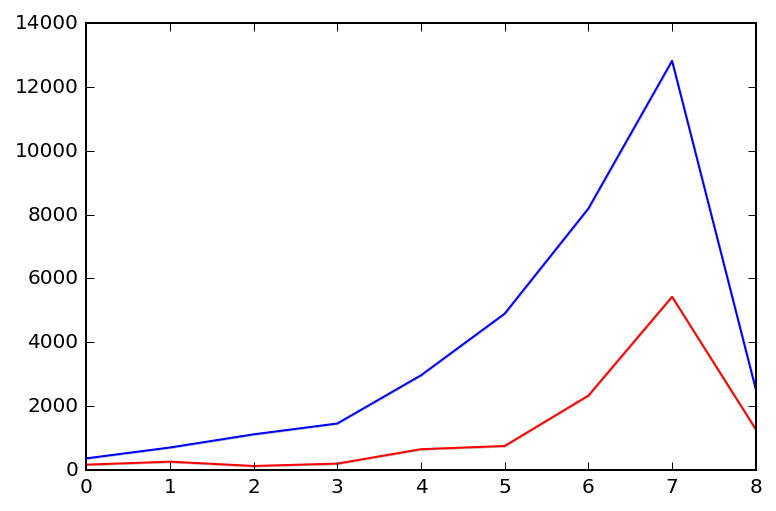

In [247]:
colors = ('red', 'blue')
for i, g in enumerate((1, 34)):
    sns.tsplot(timeseries.query('category_id == {}'.format(g)).meetup_groups, color=colors[i])

In [57]:
nuts = gpd.GeoDataFrame.from_file('data/nuts_rg_60m_2010_lvl_1.geojson')
uk_nuts = nuts[nuts.NUTS_ID.apply(lambda x: 'UK' in x)]

In [58]:
import shapely
import shapely.geometry
import geopandas.tools
groups['geometry'] = groups.apply(lambda x: shapely.geometry.Point(x['lon'], x['lat']), axis=1)

In [81]:
groups_gdf = gpd.GeoDataFrame(groups)
groups_gdf.crs = {'init': 'epsg:4326'}

ValueError: need at least one array to concatenate

In [92]:
groups_gdf.head()

,Unnamed: 0,category,city,country,created,description,group_photo,id,join_mode,lat,...,state,timezone,topics,urlname,utc_offset,visibility,who,topics_urlkeys,category_id,geometry
0,0,"{u'shortname': u'language', u'name': u'languag...",London,GB,1205260880000,<p>Es un intercambio de ingles y espanol. Haz ...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1058118,closed,51.549999,...,17,Europe/London,"[{u'name': u'Spanish Language', u'urlkey': u's...",spanish-896,0,public_limited,Members,spanish language-exchange spanish-language-london,16,POINT (-0.230000004172 51.5499992371)
1,1,"{u'shortname': u'hobbies-crafts', u'name': u'h...",London,GB,1205962371000,"<p>Formed in 2008, the Croydon Filmmaking meet...","{""thumb_link"": ""http://photos3.meetupstatic.co...",1070873,approval,51.520000,...,17,Europe/London,"[{u'name': u'Film Industry', u'urlkey': u'film...",filmind-351,0,members,Film People,filmind dv screenwriters indiefilm video film-...,15,POINT (-0.10000000149 51.52000045779999)
2,2,"{u'shortname': u'socializing', u'name': u'soci...",London,GB,1206119861000,"<p style=""text-align : justify"">A WALK WELCOME...","{""thumb_link"": ""http://photos4.meetupstatic.co...",1073622,open,51.520000,...,17,Europe/London,"[{u'name': u'Fitness', u'urlkey': u'fitness', ...",Londons-Social-Urban-Walks,0,public,London Strollers,fitness singles hiking walkers newintown self-...,31,POINT (-0.10000000149 51.52000045779999)
3,3,"{u'shortname': u'socializing', u'name': u'soci...",Twickenham,GB,1206365647000,<p>Meet other people who are interested in wid...,"{""thumb_link"": ""http://photos1.meetupstatic.co...",1077504,open,51.450001,...,17,Europe/London,"[{u'name': u'New In Town', u'urlkey': u'newint...",twickenham-social-meetup,0,public_limited,Twickers Locals,newintown rugby neighbors socialnetwork social...,31,POINT (-0.330000013113 51.4500007629)
4,4,"{u'shortname': u'tech', u'name': u'tech', u'id...",London,GB,1206457505000,Meet other locals who earn their living from t...,"{""thumb_link"": ""http://photos4.meetupstatic.co...",1079363,open,51.520000,...,17,Europe/London,"[{u'name': u'Web Design', u'urlkey': u'webdesi...",internetpro-56,0,public,Internet Professionals,webdesign media internetpro web,34,POINT (-0.10000000149 51.52000045779999)


In [ ]:
lo

In [107]:
groups_gdf_london_count.columns

Index([u'name_right', u'id'], dtype='object')

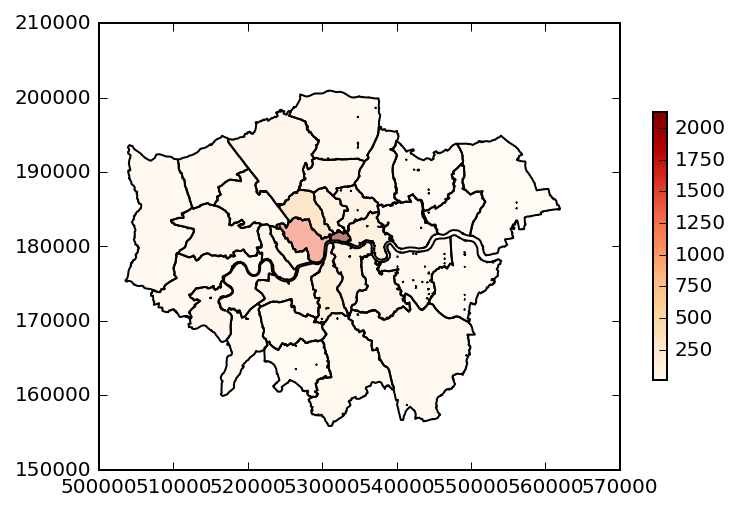

In [112]:
plt.subplots?

In [113]:
ax

IOError: [Errno 2] No such file or directory: 'figure/maps.pdf'

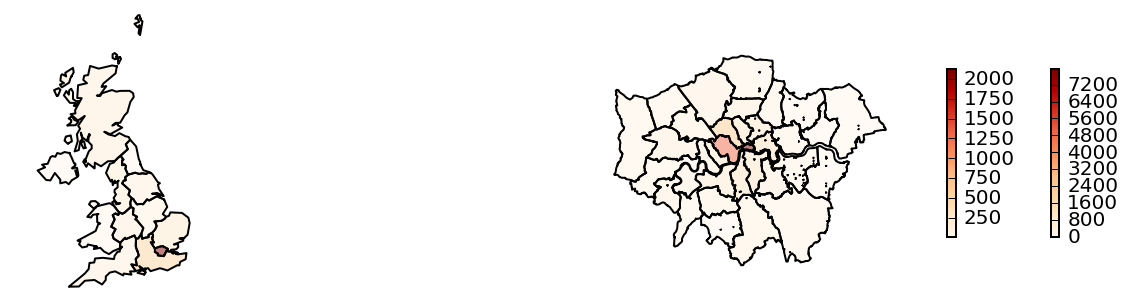

In [116]:
fig, ax = plt.subplots(figsize=(12,2.5), ncols=2)

pointInPolys2 = geopandas.tools.sjoin(groups_gdf, uk_nuts, how='inner')
gpointSumByPoly2 = pointInPolys2.groupby(by='NUTS_ID')[['id']].count().reset_index().rename({"id": "groupcount"})
uk_nuts_merge2 = uk_nuts.merge(gpointSumByPoly2, how='left', left_on="NUTS_ID", right_on="NUTS_ID").fillna(0)
uk_nuts_merge2 = uk_nuts_merge2.to_crs(epsg='27700')
geopandas.plotting.plot_dataframe(uk_nuts_merge2, ax=ax[0], column='id', colormap='OrRd', legend=True)

london = gpd.read_file('data/london.geojson')
groups_gdf_london = geopandas.tools.sjoin(groups_gdf, london, how='inner')
groups_gdf_london_count = groups_gdf_london.groupby(by='name_right')[['id']].count().reset_index()
london_withcounts = london.merge(groups_gdf_london_count, how='left', left_on="name", right_on="name_right").fillna(0)
# uk_nuts_merge2 = uk_nuts_merge2.to_crs(epsg='27700')

geopandas.plotting.plot_dataframe(
    london_withcounts.to_crs(epsg='27700'),
    ax=ax[1], column='id', colormap='OrRd', legend=True)

for ax_i in ax.ravel():
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.axis('off')
    ax_i.set_aspect(1)
plt.savefig("figure/maps.pdf")

In [170]:
groups[[groups.category_id==34]

ValueError: Item wrong length 1 instead of 13844.

In [172]:
len(set(t_groups_ids))

1559

In [175]:
groups.category.unique()

TypeError: unhashable type: 'dict'